In [ ]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext autotime

time: 218 µs (started: 2022-07-31 07:56:15 +00:00)


In [ ]:
from math import sqrt, floor
import numpy as np

def naive_sharding(ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """
    
    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.mat(np.zeros((k,n)))

    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m/k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shards)
    # Sum columns of shards, get means; these columnar means are centroids
    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids

def _get_mean(sums, step):
    """
    Vectorizable ufunc for getting means of summed shard columns.
    
    Parameters
    ----------
    sums : float
        The summed shard columns.
    step : int
        The number of instances per shard.
    Returns
    -------
    sums/step (means) : numpy array
        The means of the shard columns.
    """

    return sums/step

time: 45.2 ms (started: 2022-07-31 07:56:19 +00:00)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

time: 2.24 s (started: 2022-07-31 07:56:22 +00:00)


In [ ]:
df = pd.read_csv("https://github.com/sumit07041997/Thesis/blob/0101b6aaa4275ae4ae6bb63689453d3d8f047b8d/Student.csv?raw=true",delimiter='\t')
df

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low
...,...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89,High
399,0.85,0.82,0.66,0.83,0.83,High
400,0.56,0.60,0.77,0.13,0.32,Low
401,0.66,0.68,0.81,0.57,0.57,Middle


time: 617 ms (started: 2022-07-31 07:56:27 +00:00)


In [ ]:
lable = df[' UNS'].copy()
data = df.drop(' UNS',axis=1)
lable.value_counts()

Low         129
Middle      122
High        102
Very Low     26
very_low     24
Name:  UNS, dtype: int64

time: 11.5 ms (started: 2022-07-29 15:35:18 +00:00)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data= scaler.fit_transform(data)

time: 16.2 ms (started: 2022-07-29 15:35:35 +00:00)


**Elbow Method**

1. Using Distortion 
- Computes the sum of squared distances from each point to its assigned center.

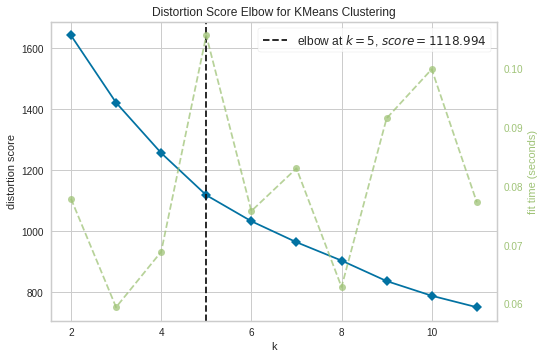

time: 1.18 s (started: 2022-07-29 15:35:38 +00:00)


In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='distortion'
)
visualizer.fit(data)        
visualizer.show() 

# 2. Silhouette score 


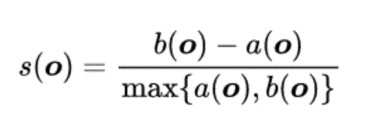

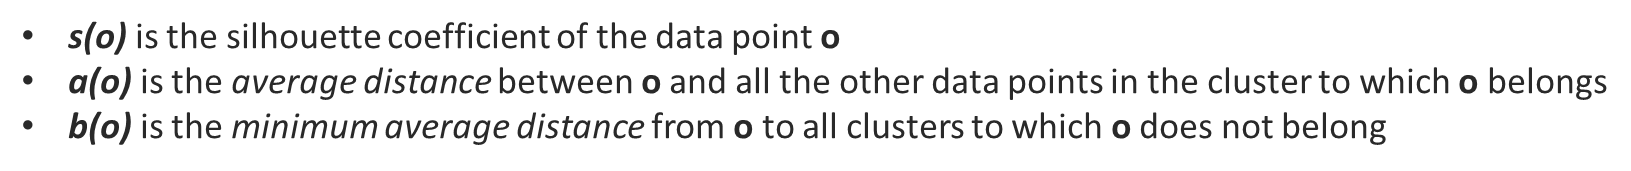

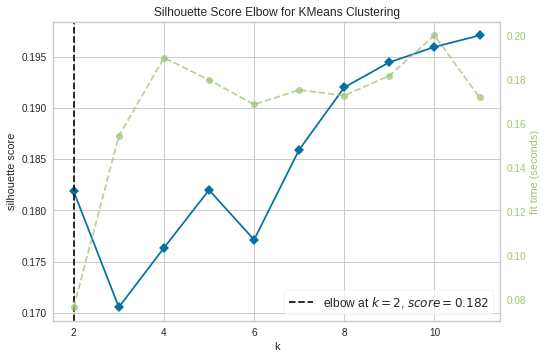

time: 2.12 s (started: 2022-07-29 15:37:17 +00:00)


In [ ]:
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='silhouette')
visualizer.fit(data) 
visualizer.show() 

3. calinski_harabasz score 
- computes the ratio of dispersion between and within clusters.

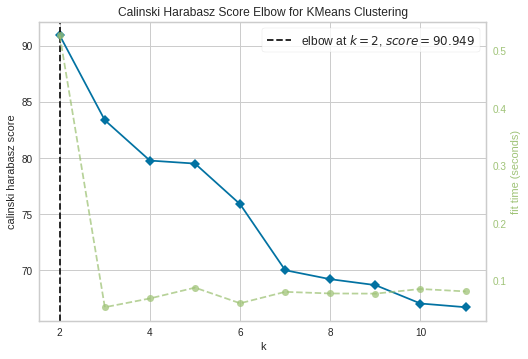

time: 1.57 s (started: 2022-07-29 15:38:36 +00:00)


In [ ]:
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='calinski_harabasz')
visualizer.fit(data) 
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=4,init='random', random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  19
time: 80.4 ms (started: 2022-07-29 15:41:29 +00:00)


In [ ]:
kmeans = KMeans(n_clusters=4,init='k-means++', random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  27
time: 77.4 ms (started: 2022-07-29 15:41:31 +00:00)


In [ ]:
kmeans = KMeans(n_clusters=3,init=naive_sharding(data,3), random_state=0,n_init=1).fit(data)
print('Iterations: ',kmeans.n_iter_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Iterations:  12
time: 231 ms (started: 2022-07-29 15:56:06 +00:00)


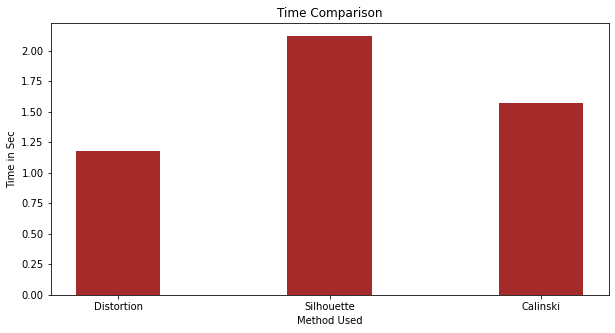

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 

method = ['Distortion','Silhouette','Calinski']
time = [1.18,2.12,1.57]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, time, color ='brown',
        width = 0.4)
 
plt.xlabel("Method Used")
plt.ylabel("Time in Sec")
plt.title("Time Comparison")
plt.show()